# Import Libraries

In [59]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from monai.transforms import CropForeground
# import tensorflow as tf

# Params

In [60]:
IMG_SIZE = [384, 384]
CHANGE_MODE = 'pad' # 'pad' : 패딩으로 이미지 생성, 'resize' : 그냥 리사이즈 # 'no'
INTER = cv2.INTER_NEAREST # cv2.INTER_CUBIC. # cv2.INTER_NEAREST # cv2.INTER_CUBIC # , cv2.INTER_LINEAR, 
MIDDLE_LABEL =True # False# True
CROP = False

# Utilities

## Metadata

## Image

In [61]:
def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0 != resize):
        if CHANGE_MODE == 'pad':
            diff = resize - shape0
            pad0 = diff[0]
            pad1 = diff[1]
            pady = [pad0//2, pad0//2 + pad0%2]
            padx = [pad1//2, pad1//2 + pad1%2]
            img = np.pad(img, [pady, padx])
            img = img.reshape((*resize, ))
        elif CHANGE_MODE == 'no':
            pass
        else:
            if CROP == False:
                img = cv2.resize(img, resize, interpolation=INTER)
            else:
                cr = CropForeground(lambda x:x>40)
                img_ = img.transpose(2,0,1)
                start_, end_ = cr.compute_bounding_box(img_)
                img = img[start_[0]:end_[0], start_[1]:end_[1], :]
                img = cv2.resize(img, resize, interpolation=INTER)
                return img, start_, end_
#     img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
#     img = img.astype('float32') # original is uint16
#     mx = np.max(img)
#     if mx:
#         img/=mx # scale image to [0, 1]
    return img, [], []

def load_msk(path, start_, end_, size=IMG_SIZE):
    msk = np.load(path)
#     msk = msk.astype('float32')
#     msk/=255.0
#     msk = cv2.resize(msk, dsize=size, interpolation=cv2.INTER_NEAREST)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        if CHANGE_MODE == 'pad':
            diff = resize - shape0
            pad0 = diff[0]
            pad1 = diff[1]
            pady = [pad0//2, pad0//2 + pad0%2]
            padx = [pad1//2, pad1//2 + pad1%2]
            msk = np.pad(msk, [pady, padx, [0,0]])
            msk = msk.reshape((*resize, 3))
        elif CHANGE_MODE == 'no':
            pass
        else:
            if CROP == False:
                msk = cv2.resize(msk, size, interpolation=INTER)
            else:
                msk = msk[start_[0]:end_[0], start_[1]:end_[1], :]
                msk = cv2.resize(msk, size, interpolation=INTER)
    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')
    
def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img, start_, end_ = load_img(img_path, size=size)
        imgs[..., i]+=img
        if i == 1:
            start__, end__ = copy.deepcopy(start_), copy.deepcopy(end_)
            
    return imgs, start__, end__

# Meta Data

In [62]:
df = pd.read_csv('./train_.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')
# df['mask_path'] = df.mask_path.str.replace('../data/seg_data/', f'/tmp/')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head()

The default value of regex will change from True to False in a future version.


,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True


# 2.5D Images

In [63]:
channels=3
stride=1
if MIDDLE_LABEL:
    for idx, i in enumerate(range(-1, 2, 1)): # range(channels):
        if idx <= 0:
            df[f'image_path_{idx:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="bfill") # 맨 뒤이 nan
        else:
            df[f'image_path_{idx:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
else:
    for idx, i in enumerate(range(channels)): # range(channels):
        df[f'image_path_{idx:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
df.image_paths[0]

['../data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '../data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '../data/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png']

In [64]:
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty,image_path_00,image_path_01,image_path_02,image_paths
0,case123_day20_slice_0001,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
1,case123_day20_slice_0002,123,20,2,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
2,case123_day20_slice_0003,123,20,3,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
3,case123_day20_slice_0004,123,20,4,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
4,case123_day20_slice_0005,123,20,5,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...


# Check Mask

In [20]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[df['empty']==0].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = df[df['id']==id_]
    img = load_img(idf.image_path.iloc[0])
    mask = load_msk(idf.mask_path.iloc[0])
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

TypeError: load_msk() missing 2 required positional arguments: 'start_' and 'end_'

<Figure size 1440x360 with 0 Axes>

In [21]:
np.unique(mask)

NameError: name 'mask' is not defined

# Check 2.5D Data

AttributeError: 'tuple' object has no attribute 'astype'

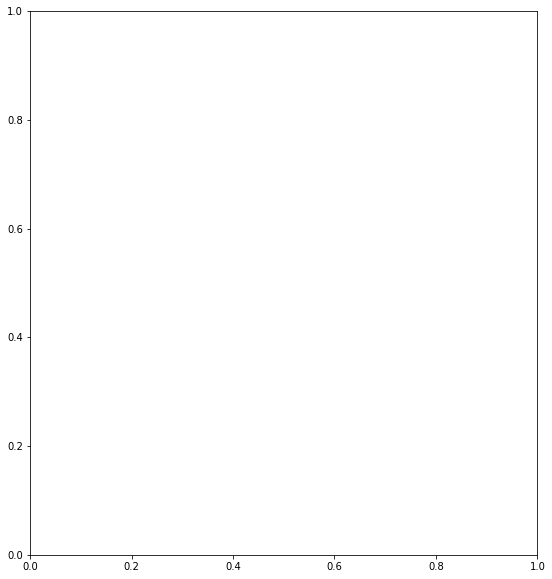

In [10]:
idx = 40

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(df.image_path[idx]).astype('float32')
img/=img.max()
plt.imshow(img)
plt.axis('off')


plt.subplot(1, 2, 2)
imgs = load_imgs(df.image_paths[idx]).astype('float32')
imgs/=imgs.max(axis=(0,1))
plt.imshow(imgs)
plt.axis('off')

plt.tight_layout()
plt.show()

# Write Mask

In [65]:
def save_mask(id_):
    row = df[df['id']==id_].squeeze()
    
    img_paths = row.image_paths
    imgs, start_, end_ = load_imgs(img_paths)
    # np.save(f'{IMAGE_DIR}/{id_}.npy', imgs)
    
    msk_path = row.mask_path
    msk = load_msk(msk_path, start_, end_)
    # print('mask', msk.shape)
    large = msk[:,:,0][...,None]
    small = msk[:,:,1][...,None]
    stoma = msk[:,:,2][...,None]
    # np.save(f'{MASK_DIR}/{id_}.npy', msk)
    # print(large.shape)
    if large.shape == (384,384,3):
        raise
    np.save(f'{MASK_DIR}/{id_}.npy', stoma)
    return

In [26]:
df = pd.read_csv('./train_.csv')

In [36]:
np.nan is  df.segmentation[0]

True

In [48]:
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/png//train/case123/case123_day20/scans...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/png//train/case123/case123_day20/scans...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/png//train/case123/case123_day20/scans...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,../data/train/case123/case123_day20/scans/slic...,266,266,../data/png//train/case123/case123_day20/scans...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,../data/train/case123/case123_day20/scans/slic...,266,266,../data/png//train/case123/case123_day20/scans...


In [42]:
df.segmentation.map(lambda x:x is np.nan)

0         True
1         True
2         True
3         True
4         True
          ... 
115483    True
115484    True
115485    True
115486    True
115487    True
Name: segmentation, Length: 115488, dtype: bool

In [47]:
df[df.segmentation.map(lambda x:x is not np.nan)].segmentation.iloc[0]

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

In [23]:
# ! rm -rf ../data/images_512_512_resize_1_3_

In [66]:
# IMAGE_DIR = f'../data/images_{IMG_SIZE[0]}_{IMG_SIZE[1]}_{CHANGE_MODE}_{stride}_{channels}_middle'
MASK_DIR = f'../data/masks_{IMG_SIZE[0]}_{IMG_SIZE[1]}_{CHANGE_MODE}_{stride}_{channels}_stoma'
# !mkdir -p $IMAGE_DIR && mkdir -p $MASK_DIR
!mkdir -p $MASK_DIR

In [67]:
ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_)\
                                             for id_ in tqdm(ids, total=len(ids)))

  0%|          | 0/38496 [00:00<?, ?it/s]

# Check Saved Mask

In [14]:
np.load(glob('../data/masks_384_384_pad_1_3_large/*')[0]).shape

(1, 384, 3)

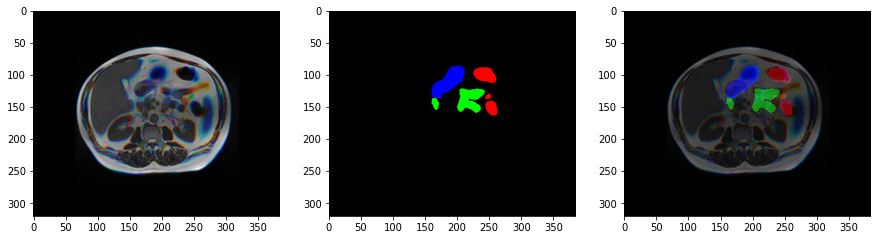

In [36]:
plt.figure(figsize=(15, 5))

imgs = np.load(f'{IMAGE_DIR}/case123_day0_slice_0080.npy').astype('float32')
imgs/=imgs.max(axis=(0,1))

plt.subplot(1, 3, 1)
plt.imshow(imgs)

msk = np.load(f'{MASK_DIR}/case123_day0_slice_0080.npy').astype('float32')
msk/=255.0

plt.subplot(1, 3, 2)
plt.imshow(msk)


plt.subplot(1, 3, 3)
plt.imshow(imgs)
plt.imshow(msk, alpha=0.5)

# Save Metadata

In [37]:
df.to_csv('train_2.5.csv',index=False)

In [38]:
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty,image_path_00,image_path_01,image_path_02,image_paths
0,case123_day20_slice_0001,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
1,case123_day20_slice_0002,123,20,2,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
2,case123_day20_slice_0003,123,20,3,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
3,case123_day20_slice_0004,123,20,4,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...
4,case123_day20_slice_0005,123,20,5,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,../data/train/case123/case123_day20/scans/slic...,[../data/train/case123/case123_day20/scans/sli...


# Compress Files

In [13]:
shutil.make_archive('/kaggle/working/images',
                    'zip',
                    '/tmp',
                    'images')

'/kaggle/working/images.zip'

In [14]:
shutil.make_archive('/kaggle/working/masks',
                    'zip',
                    '/tmp',
                    'masks')

'/kaggle/working/masks.zip'

# 3D dataset

In [ ]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle



In [99]:
def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0 != resize):
        if CHANGE_MODE == 'pad':
            diff = resize - shape0
            pad0 = diff[0]
            pad1 = diff[1]
            pady = [pad0//2, pad0//2 + pad0%2]
            padx = [pad1//2, pad1//2 + pad1%2]
            img = np.pad(img, [pady, padx])
            img = img.reshape((*resize, ))
        elif CHANGE_MODE == 'no':
            pass
        else:
            img = cv2.resize(img, resize, interpolation=INTER)
        
#     img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
#     img = img.astype('float32') # original is uint16
#     mx = np.max(img)
#     if mx:
#         img/=mx # scale image to [0, 1]
    return img

def load_msk(path, size=IMG_SIZE):
    msk = np.load(path)
#     msk = msk.astype('float32')
#     msk/=255.0
#     msk = cv2.resize(msk, dsize=size, interpolation=cv2.INTER_NEAREST)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        if CHANGE_MODE == 'pad':
            diff = resize - shape0
            pad0 = diff[0]
            pad1 = diff[1]
            pady = [pad0//2, pad0//2 + pad0%2]
            padx = [pad1//2, pad1//2 + pad1%2]
            msk = np.pad(msk, [pady, padx, [0,0]])
            msk = msk.reshape((*resize, 3))
        elif CHANGE_MODE == 'no':
            pass
        else:
            msk = cv2.resize(msk, size, interpolation=INTER)
    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')
    
def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path, size=size)
        imgs[..., i]+=img
    return imgs

In [100]:
df = pd.read_csv('./train_.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')
# df['mask_path'] = df.mask_path.str.replace('../data/seg_data/', f'/tmp/')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head()

/tmp/ipykernel_136329/1205006207.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')


,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,../data/train/case123/case123_day20/scans/slic...,266,266,../data/np/train/case123/case123_day20/scans/s...,"[, , ]",0,True


In [101]:
df.image_path[0]

'../data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [103]:
df['uniq'] = df['case'].astype(str) + '_' + df['day'].astype(str)

In [111]:
df_images = df.groupby('uniq')['image_path'].apply(lambda x:list(x))

In [112]:
df_masks = df.groupby('uniq')['mask_path'].apply(lambda x:list(x))

In [116]:
df_tmp = pd.concat((df_images, df_masks), axis=1)

In [118]:
for i in df_tmp.iterrows():
    print(i[1])
    image_3d = np.zeros((*img_size, len() )
    for idx, j in enumerate(i[1].image_path):
        image_3d[..., idx] += np.load(j)
    print(image_3d)
    break

image_path    [../data/train/case101/case101_day20/scans/sli...
mask_path     [../data/np/train/case101/case101_day20/scans/...
Name: 101_20, dtype: object


IndexError: index 0 is out of bounds for axis 0 with size 0

# 배경제거

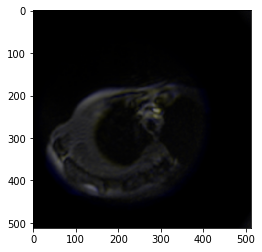

In [15]:
for i in sorted(glob('/VOLUME/jckim/data/images_512_512_resize_1_3_near_middle/*')):
    img = np.load(i)
    plt.imshow(img)
    break